In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# read in csv

df = pd.read_csv('/Users/juhee/Desktop/GA/lsmtmp/juhee/data/final_labeled.csv')

print(df.shape)
df.head()

(38325, 10)


,id,user_name,lat,long,date,text,text_clean,n_sentence,n_words,label
0,1241152458912673794,DarkDon_,40.738154,-112.101609,2020-03-20 23:59:40+00:00,TK Kirkland's Reaction To Earthquake's Ex-Wife...,tk kirkland s reaction to earthquake ex wife o...,1,17,1
1,1241152416214474753,ReallyInID,42.242918,-112.103304,2020-03-20 23:59:30+00:00,That sound you hear is NOT an earthquake. It’s...,that sound you hear is not an earthquake it s...,2,13,1
2,1241152284827856896,folsworth,40.982162,-112.104020,2020-03-20 23:58:58+00:00,he said he stocked up on ammo cause he knew Th...,he said stocked up on ammo cause knew the big ...,2,23,1
3,1241152178695405570,Colony14,42.729481,-112.107004,2020-03-20 23:58:33+00:00,"If an earthquake separates CA, WA, and OR from...",if an earthquake separate ca wa and or from t...,1,23,1
4,1241152072818364416,MonitorSismico,41.044996,-112.103864,2020-03-20 23:58:08+00:00,"#Sismo M 4 SOUTH OF BALI, #INDONESIA. 20-03-20...",sismo m south of bali indonesia utc http...,2,13,1


In [3]:
# check null values

df.isnull().sum()

id            0
user_name     0
lat           0
long          0
date          0
text          0
text_clean    0
n_sentence    0
n_words       0
label         0
dtype: int64

In [4]:
# define baseline accuracy

df['label'].value_counts(normalize = True)

1    0.511155
0    0.488845
Name: label, dtype: float64

## Modeling

In [5]:
# set up X and y and train test split

X = df['text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42, stratify = y)

In [6]:
## make your own relevant words here
# make a list of words that would automatically tag a word as relevant

relevant_words = ['earthquake']

In [7]:
# create a custom stop words list

print(len(stopwords.words('english')))

stop_words = stopwords.words('english') + relevant_words

print(len(stop_words))

179
180


### CountVectorizer()
#### Multinomial Naive Bayes and Support Vector Machine

In [29]:
# set 2 pipelines with: 1. Multinomial Bayes 2. Support Vector Machine

pipeline_mb = Pipeline([
                       ('cvec', CountVectorizer()),
                       ('mb', MultinomialNB())
                       ])

pipeline_svc = Pipeline([
                        ('cvec', CountVectorizer()),
                        ('svc', SVC())
                        ])

In [30]:
# set up a dictionary to store the best parameters

model_mb_params = {}
count_mb = 0

model_svc_params = {}
count_svc = 0

In [31]:
# set up parameters

pipe_params = {
    'cvec__max_features': [4000, 5000, 6000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.85, .9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [stop_words]
}

In [32]:
# instantiate GridSearchCV - NaiveBayes

gs_mb = GridSearchCV(pipeline_mb, 
                     param_grid = pipe_params, 
                     cv = 3) 

# instantiate GridSearchCV - SVC

gs_svc = GridSearchCV(pipeline_svc, 
                      param_grid = pipe_params, 
                      cv = 3) 

In [33]:
# increase counter as we put in different parameters

count_mb += 1

# fit the training set

gs_mb.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_mb.best_params_['score'] = gs_mb.best_score_

model_mb_params[f'model_{count_mb}'] = gs_mb.best_params_

# dictionary to a dataframe

model_mb_df = pd.DataFrame.from_dict(model_mb_params, orient = 'index')

In [34]:
model_mb_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,score
model_1,0.85,6000,1,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",0.717919


In [35]:
# increase counter as we put in different parameters

count_svc += 1

# fit the training set

gs_svc.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_svc.best_params_['score'] = gs_svc.best_score_

model_svc_params[f'model_{count_svc}'] = gs_svc.best_params_

# dictionary to a dataframe

model_svc_df = pd.DataFrame.from_dict(model_svc_params, orient = 'index')

In [36]:
model_svc_df

,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,score
model_1,0.85,6000,3,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",0.893991


In [37]:
# train set score

print(f'Multinomial Naive Bayes: {gs_mb.score(X_train, y_train)}')
print(f'\nSVC: {gs_svc.score(X_train, y_train)}')

Multinomial Naive Bayes: 0.7375861666082486

SVC: 0.9519024808194103


In [38]:
# test set score

print(f'Multinomial Naive Bayes: {gs_mb.score(X_test, y_test)}')
print(f'\nSVC: {gs_svc.score(X_test, y_test)}')

Multinomial Naive Bayes: 0.7227229601518027

SVC: 0.8995888678051865


In [39]:
# find the best parameters for both models

print(f'Multinomial Naive Bayes: \n{gs_mb.best_params_}')
print(f'\nSVC: \n{gs_svc.best_params_}')

Multinomial Naive Bayes: 
{'cvec__max_df': 0.85, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why'

In [40]:
# find the best estimators for both models

print(f'Multinomial Naive Bayes: \n{gs_mb.best_estimator_}')
print(f'\nSVC: \n{gs_svc.best_estimator_}')

Multinomial Naive Bayes: 
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=6000,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mb', MultinomialNB())])

SVC: 
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.85, max_features=6000, min_df=3,
                                 ngram_range=(1, 2),
       

In [41]:
# predictions

y_preds = gs_svc.predict(X_test)

# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

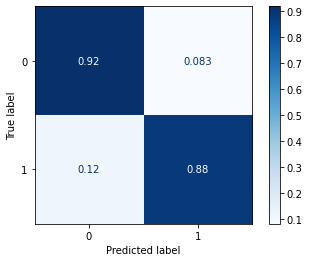

In [42]:
# view confusion matrix

plot_confusion_matrix(gs_svc, X_test, y_test, cmap = 'Blues', normalize = 'true');

### TfidfVectorizer()
#### Multinomial Naive Bayes and Support Vector Machine

In [43]:
# set up 2 pipelines with: 1. Multinomial Naive Bayes 2. SVC

pipe_mb_t = Pipeline([
                      ('tvec', TfidfVectorizer()),
                      ('mb', MultinomialNB())
                     ])

pipe_svc_t = Pipeline([
                       ('tvec', TfidfVectorizer()),
                       ('svc', SVC())
                      ])

In [44]:
# set up a dictionary to store the best parameters

t_mb_params = {}
t_count_mb = 0

t_svc_params = {}
t_count_svc = 0

In [45]:
# search over the following values of hyperparameters:

pipe_tvec_params = {
    'tvec__max_features': [4000, 5000, 6000],
    'tvec__stop_words': [stop_words],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__min_df': [0.001, 0.002, 0.003],
    'tvec__max_df': [0.85, 0.9, 0.95]
}

In [46]:
# instantiate GridSearchCV

gs_mb_t = GridSearchCV(pipe_mb_t,
                       param_grid = pipe_tvec_params,
                       cv = 3)

gs_svc_t = GridSearchCV(pipe_svc_t,
                        param_grid = pipe_tvec_params,
                        cv = 3)

In [47]:
# increase counter as we put in different parameters

t_count_mb += 1

# fit the training set

gs_mb_t.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_mb_t.best_params_['score'] = gs_mb_t.best_score_

t_mb_params[f'model_{t_count_mb}'] = gs_mb_t.best_params_

# dictionary to a dataframe

t_mb_df = pd.DataFrame.from_dict(t_mb_params, orient = 'index')

In [48]:
t_mb_df

,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score
model_1,0.85,4000,0.001,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",0.695954


In [49]:
# increase counter as we put in different parameters

t_count_svc += 1

# fit the training set

gs_svc_t.fit(X_train, y_train)

# best score is not captured in parameters -> create a key 'score' to store the info

gs_svc_t.best_params_['score'] = gs_svc_t.best_score_

t_svc_params[f'model_{t_count_svc}'] = gs_svc_t.best_params_

# dictionary to a dataframe

t_svc_df = pd.DataFrame.from_dict(t_svc_params, orient = 'index')

In [50]:
t_svc_df

,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score
model_1,0.85,4000,0.001,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...",0.891771


In [51]:
# best scores

print(f'Multinomial Naive Bayes: {gs_mb_t.best_score_}')
print(f'\nSVC: {gs_svc_t.best_score_}')

Multinomial Naive Bayes: 0.6959535771312848

SVC: 0.8917708455037583


In [52]:
# train data accuracy score 

print(f'Multinomial Naive Bayes: {gs_mb_t.score(X_train, y_train)}')
print(f'\nSVC: {gs_svc_t.score(X_train, y_train)}')

Multinomial Naive Bayes: 0.7100517973283483

SVC: 0.9593020991548857


In [53]:
# test data accuracy score 

print(f'Multinomial Naive Bayes: {gs_mb_t.score(X_test, y_test)}')
print(f'\nSVC: {gs_svc_t.score(X_test, y_test)}')

Multinomial Naive Bayes: 0.7043010752688172

SVC: 0.8932637571157496


In [54]:
# best estimators

print(f'Multinomial Naive Bayes: \n{gs_mb_t.best_estimator_}')
print(f'\nSVC: \n{gs_svc_t.best_estimator_}')

Multinomial Naive Bayes: 
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=0.001,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mb', MultinomialNB())])

SVC: 
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.85, max_features=4000, min_df=0.001,
                                 ngram_ran

In [55]:
# best parameters

print(f'Multinomial Naive Bayes: \n{gs_mb_t.best_params_}')
print(f'\nSVC: \n{gs_svc_t.best_params_}')

Multinomial Naive Bayes: 
{'tvec__max_df': 0.85, 'tvec__max_features': 4000, 'tvec__min_df': 0.001, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', '

In [56]:
# predictions

y_preds_t = gs_svc_t.predict(X_test)

# confusion matrix values

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_t).ravel()

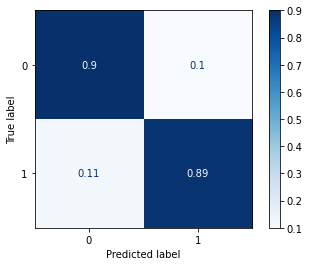

In [57]:
# view confusion matrix

plot_confusion_matrix(gs_svc_t, X_test, y_test, cmap = 'Blues', normalize = 'true');
